# CarND Advanced Lane Lines

The code used in the project and the final annotated video can be found [here](https://github.com/itoyjakra/Udacity_CarND/tree/master/Term1/Project4). The files Frame.py and Lane.py define the Frame and Lane classes respectively. The file DetectLane.py has the pipeline for lane detection.

## 1. Camera Calibration

The camera calibration is performed in the 'CalibrateCamera' procedure in DetectLane.py. It uses the provided chessboard patterns to detect the corners of the chessboard first. The detected corners used in conjunction of a regular square greed with the same number of vertices is used to remove the camera distortion. Here's an example: 

In [1]:
from DetectLane import CalibrateCamera
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

mtx, dist = CalibrateCamera()

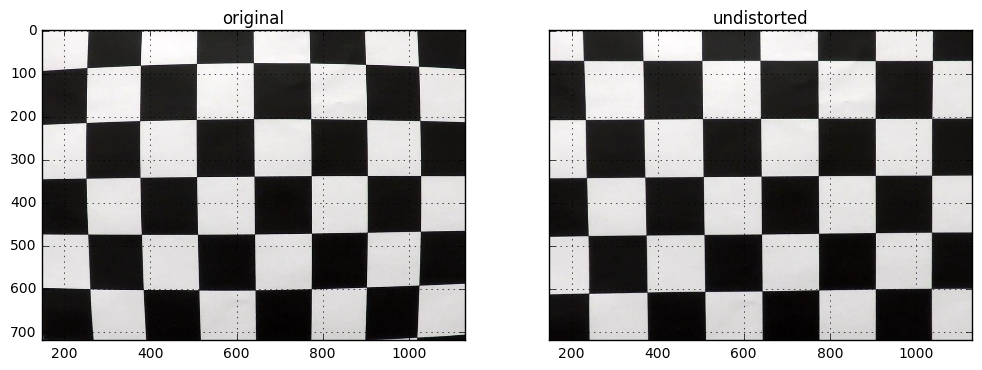

In [2]:
f = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(f, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4], sharey=True)
ax1.imshow(f)
ax1.grid()
ax1.set_title("original")
ax2.imshow(undist)
ax2.grid()
ax2.set_title("undistorted")

## 2. Pipeline

### 2a. Correct image distortion 

The pipeline to process a single frame of image starts by correcting for camera distortion using the transformation learnt earlier.

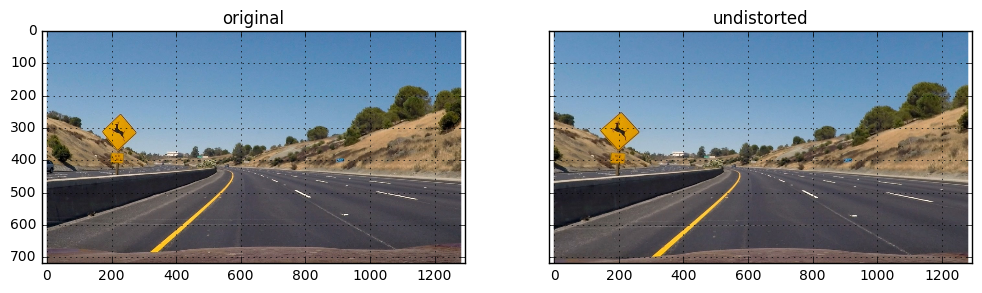

In [4]:
im_jpg = mpimg.imread('test_images/test2.jpg')
undist_img = cv2.undistort(im_jpg, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 3], sharey=True)
ax1.imshow(im_jpg)
ax1.grid()
ax1.set_title("original")
ax2.imshow(undist_img)
ax2.grid()
ax2.set_title("undistorted")

### 2b. Apply Filters

The undistorted image is then processed through a combination of color and gradient filters to obtain a binary image. This is the step where a lot of trial and error is involved. The final combination used the red channel of the RGB filter, hue and saturation channels of the HSV filter and a combination of the x component, direction and magnitude  of the Sobel gradient. The implementation can be found in the one_frame_pipeline() procedure under DetectLane.py. Here's an example of the binary image obtained:

In [5]:
from Frame import Frame

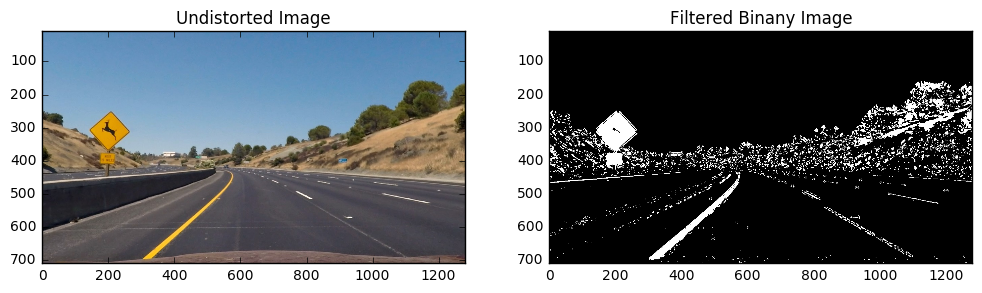

In [8]:
#undist = cv2.undistort(im_jpg, mtx, dist, None, mtx)
im = Frame(undist_img)

# apply color channel thresholds
ch1 = im.hsv_select(thresh=(150, 255), channel=1)
ch2 = im.hsv_select(thresh=(200, 255), channel=2)
ch3 = im.rgb_select(thresh=(0, 30))

# apply Sobel gradient thresholds
dir_binary = im.dir_thresh(sobel_kernel=15, thresh=(0.5, 1.1))
mag_binary = im.mag_thresh(sobel_kernel=15, thresh=(20, 125))
sobel_binary = im.sobel_thresh(sobel_kernel=15, orient='x', thresh=(200, 255))

# combine filters
combined = np.zeros_like(dir_binary)
combined[(mag_binary == 1) & (dir_binary == 1) | (sobel_binary == 1)] = 1
combined = combined.astype(np.uint8)
ch = ((ch1 | ch2) & ch3) | combined

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=[12, 3])
ax1.imshow(undist_img)
ax1.set_title("Undistorted Image")
ax2.imshow(ch, cmap='gray')
ax2.set_title("Filtered Binany Image")

### 2c. Perspective Transform

For lane detection, the binany image is undergone through a perspective transform. The actual transformation matrix is obtained by choosing an image with straight lanes as the source image and casting them onto a destination image where they appear as a pair of 'parallel' straight lines. The source and destination points are hard coded and the transformation is performed in the procedure PerspectiveTransform() under DetectLane.py. Here's how the original lanes appear after the perspective transform:

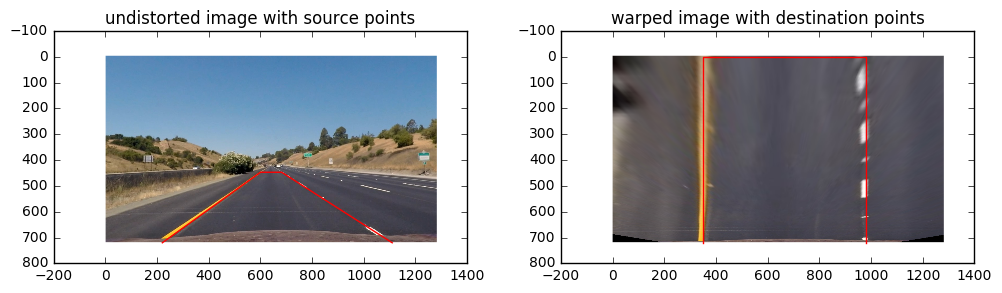

In [23]:
mtx, dist = CalibrateCamera()
img = mpimg.imread("test_images/straight_lines1.jpg")

undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
offset = 100
img_size = (gray.shape[1], gray.shape[0])
src = np.float32([(275, 680),  (600, 447), (682, 447), (1040, 680)])
src = np.float32([(220, 720),  (600, 447), (682, 447), (1110, 720)])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
dst = np.float32([[350, img_size[1]], [350, 0], [980, 0], [980, img_size[1]]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, img_size)
Minv = cv2.getPerspectiveTransform(dst, src)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 3])
ax1.imshow(undist)
ax1.plot(src[:,0], src[:,1], '-r')
ax1.set_title("undistorted image with source points")
ax2.imshow(warped)
ax2.plot(dst[:,0], dst[:,1], '-r')
ax2.set_title("warped image with destination points")

Using the perspective transform matrix, the binany image obtained in the last step is transformed as follows:

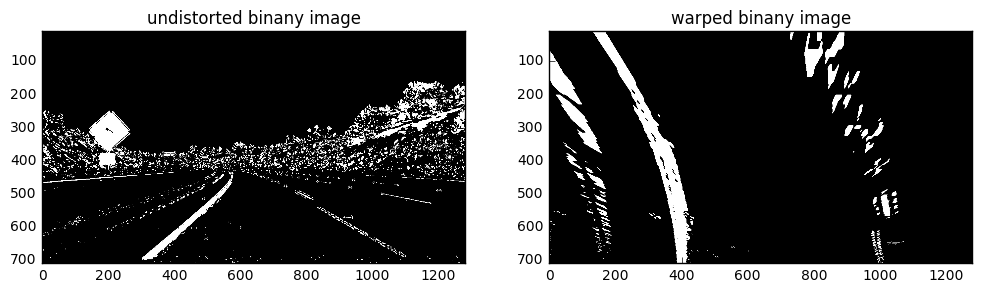

In [22]:
img_size = (im.image.shape[1], im.image.shape[0])
warped_img = cv2.warpPerspective(ch, M, img_size)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=[12, 3])
ax1.imshow(ch, cmap='gray')
ax1.set_title("undistorted binany image")
ax2.imshow(warped_img, cmap='gray')
ax2.set_title("warped binany image")

### 2d. Lane detection

The lane detection process consists of two parts.

* The warped image is broken down into several (9 in my case) horizontal strips. The location of the left and right lane centers in each of these strips are detected by looking at the peak of the signal obtained by convolving the strip with a rectangular window.

* For each of the left and right lanes, a second degree polynomial is fitted through the strip peak locations obtained before.

The figure below shows an example of the center of the left and right lanes obtained through convolving a window, represented by the green box, for each strip in the image. The corresponding best fitted polynomial lines are also depicted.

The entire process is implemented in the find_window_centroids() procedure in the Lane class.

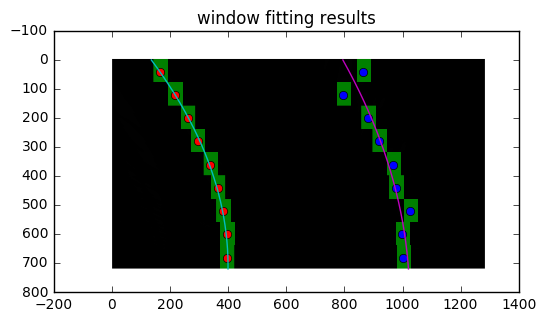

In [14]:
from Lane import Lane

window_width = 50
window_height = 80
margin = 100

window_params = (window_width, window_height, margin)
lane = Lane(undist_img, warped_img, window_params)
cents = lane.find_window_centroids()
lane.display_lane_centers(cents)

### 2e. Radius of Curvature calculation and final lane rendering

The radii of curvatue for each of the lane lines is calculated in the radius_of_curvature() procedure of the Lane class.

Finally the area between the fitted lines is highlighted to show the detected lane area. It is implemented in the  plot_lane() procedure of Lane class.

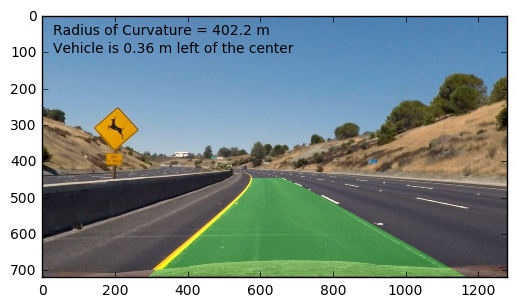

In [25]:
roc, offset = lane.radius_of_curvature(cents)
fin_img, roc, offset = lane.plot_lane(Minv, (roc, offset), window_centroids=cents)
plt.imshow(fin_img)

if offset > 0:
    side = 'right'
else:
    side = 'left'
plt.text(30, 50, "Radius of Curvature = %.1f m" % roc)
plt.text(30, 100, "Vehicle is %.2f m %s of the center" % (np.abs(offset), side))

## 3. Video rendering

Each frame of the project video is processed in the video_pipeline() by calling the one_frame_pipeline() procedure to process individual frames in the DetectLane.py file.

* The final annotated video is project_video_annotated.mp4.
* The final annotated challenge video is challenge_annotated.mp4.

## 4. Discussions

Detecting lanes in the project video was relatively simple, creating a good filtered binany image was all it took. However, this simple pipeline did not work for the challenge video because of mainly two reasons - 1. fade lane markings and 2. pavement noise that produces strong signal. Several modifications were made to detect lanes in the challenge video:

* A LaneSeries class was created to keep track of many features of each lane

* The polynomial fit was weighted to put trust on lane lines closer to the car

* Rejecting spurious lane markings based on expected lane width

* Searching lanes in a narrow region based on detected location from previous frame

With these modifications, the challenge video worked at a reasonable level except near the end where the pipeline had hard time detecting lines away from the car because they are very low contrast.

Modifications that can improve the pipeline:

* Search for lane detection parameters that works well with lanes with very small radius of curvature, as in the harder challenge video.

* Create a mechanism to maintain the average lane location detected by consecutive frames.